# Classical Euler methods

### Table of contents
 1. Chapter 2: Classical Methods
    1. [Section 1.1: Explicit Euler](#explicitEuler)
    1. [Section 1.2: Implicit Euler](#implicitEuler)

In [ ]:
# If you do not have numpy, matplotlib, scipy or nodepy, run this cell
!pip install numpy
# This is the basic package in python with all the numerical functions

!pip install scipy
# This package has some functions to deal with polynomials

!pip install matplotlib
# This package allows to  plot

!pip install nodepy
# This package has some interesting features for RK methods

In [46]:
# We need a couple of packages in this chapter
import numpy as np  
# This is the basic package in python with all the numerical functions

import matplotlib.pyplot as plt 
# This package allows to  plot

from scipy import optimize
# This module has optimization tools

from nodepy import * 
#This package already implemented some functions for Runge Kutta and multistep methods

We want to **approximate** the ODE on $I:=[t_0, t_{end}]\subset \mathbb{R}$ for the unknown variable $y:I\to \mathbb{R}^{S}$ with *continuous* function $F:I\times \mathbb{R}^S\to\mathbb{R}^S$

$$
\begin{equation}
\begin{cases}\label{eq:IVP}
\frac{dy}{dt} = F(t,y(t)),\\
y(0)=y_0.
\end{cases}
\end{equation}
$$

* Why approximate? Solution may be unknown, or too complicated to be solved analytically.
* How we want to approximate? We want to be **accurate** and we want to preserve the physical properties we have seen before.

## Explicit Euler <a id='explicitEuler'></a>

Consider the time interval $I=[t_0,t_{end}]$ and let us subdivide it into $N$ subintervals, 

$$t_0=t^0<t^1< \dots <t^n < \dots <t^N=t_{end}.$$

We approximate naïvely the integral form

$$ y(t^{n+1})=y(t^n) +\int_{t^n}^{t^{n+1}} F(s,y(s))ds \approx y(t^n) -\underbrace{(t^{n+1}-t^n)}_{\Delta t^n} F(t^n,y(t^n)) $$

leading to the method (forward Euler/explicit Euler), where we use $y^n$ to approximate $y(t^n)$

$$
\begin{cases}
y^0=y_0,\\
y^{n+1}=y^n+\Delta t^n F(t^n,y^n), \qquad n=0,\dots, N-1.
\end{cases}
$$

In [80]:
# Simple implementation of the method
# Input are F, (t^0,...,t^N), y_0
def explicitEuler(func, tspan, y_0):
    N_time=len(tspan)  # N+1
    dim=len(y_0)          # S
    y=np.zeros((dim,N_time))    # initializing the variable of solutions    
    y[:,0]=y_0                 # first timestep 
    for n in range(N_time-1):    # n=0,..., N-1
        y[:,n+1]=y[:,n]+(tspan[n+1]-tspan[n])*func(y[:,n],tspan[n])
    return tspan, y 

Test on $$
\begin{equation}\label{eq:linear_test}
\begin{aligned}
& \begin{cases}
c_1'(t)=c_2(t)-5c_1(t),\\
c_2'(t)=5c_1(t)-c_2(t),
\end{cases}\\
 &c_1(0)=c_1^0=0.9, \quad  &c_2(0)=c_2^0=0.1 \, ,\\
 &t\in [0,3].
\end{aligned}
\end{equation}
$$


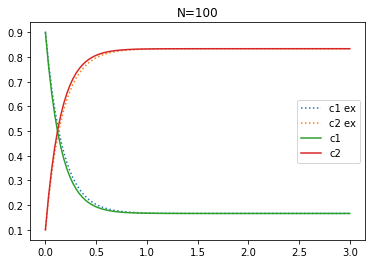

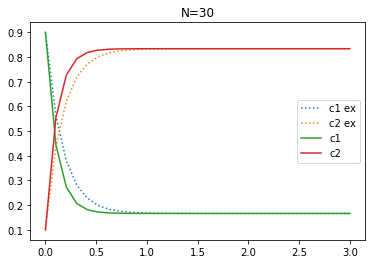

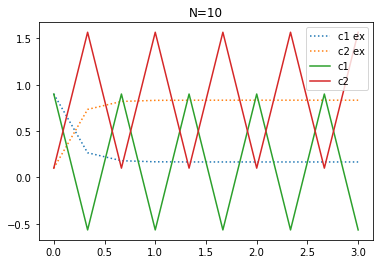

In [22]:
def linSysF(y,t=0):
    # evolution function 
    F=np.zeros(np.shape(y))
    F[0] = y[1]-5*y[0]
    F[1] = -F[0]
    return F

for N in [100,30,10]:
    tspan=np.linspace(0,3,N)
    y0=np.array([0.9,0.1])

    tt,yy=explicitEuler(linSysF,tspan,y0)

    A=np.array([[-5,1],[5,-1]])

    y_exact=np.zeros((len(y0),len(tt)))
    for it, t in enumerate(tt):
        y_exact[:,it]=y0+(1-np.exp(-6*t))/6*np.dot(A,y0)

    plt.figure()
    plt.plot(tt,y_exact[0,:],":", label="c1 ex")
    plt.plot(tt,y_exact[1,:],":", label="c2 ex")

    plt.plot(tt,yy[0,:],label="c1")
    plt.plot(tt,yy[1,:],label="c2")
    plt.title("N=%d"%N)
    plt.legend()

Preliminary, we can observe that
1. The more the points we put in the time discretization the better the solution gets
1. Explicit Euler does not preserve **unconditionally** the positivity of the solution ($N=10$)
1. The total mass is conserved 

$$ c_1^{n+1}+c_2^{n+1}=c_1^{n}+c_2^{n}+ \Delta t\left( -5c_1^{n}+c_2^{n}+5c_1^{n}-c_2^{n} \right) = c_1^{n}+c_2^{n} $$

### Error analysis
The error that we observe 
$$e_n=y(t^n)-y^n$$

is composed of several parts that we can divide and study separately.

### Theorem Convergence (Lax)
If a method is stable and consistent then it is convergent.

#### Consistency error
Given the exact solution $y(t)$, we define the consistency error to be

$$
\varepsilon_n = y(t^{n+1})-y(t^n) - \Delta t F(t^n,y(t^n)) = \int_{t^n}^{t^{n+1}} y'(t) -y'(t^n)\, dt.
$$

Notice that $|\varepsilon_n|\leq \Delta t \omega (y',\Delta t)$, where $\omega$ is the modulus of continuity of a bounded function, i.e.,
$$
\omega(f,\Delta t):= \max_{t,t': |t-t'|\leq \Delta t} |f(t)-f(t')|.
$$

Essentially, this is the error that we obtain by substituting the exact solution inside the method. It is one of the 2 ingredients that leads the error of a method.

Going back to the error, we observe that

$$
e_{n+1}=y(t^{n+1})-y^{n+1}=e_n +\varepsilon_n +\Delta t \big(f(t^n,y(t^n))-f(t^n,y^n)\big)
$$

using the Lipschitz continuity of $f$, we have

$$
|e_{n+1}|\leq |e_n| +|\varepsilon_n| +\Delta t L|y(t^n)-y^n| =(1+L\Delta t)|e_n| +|\varepsilon_n|.
$$

Using the **Discrete Gronwall Lemma** we obtain that

$$
|e_{n}|\leq e^{L|t^n-t^0|}|e_0| + \sum_{i=0}^{n-1} e^{L(t^n-t^{i+1})}|\varepsilon_i|.
$$

This tells us that, except for the initial error (that usually we can bound accurately or know its error), the consistency error leads this sum. So, if we keep $\varepsilon_n$ small enough, the final error will be small enough. 


Using the estimation for $\varepsilon_i$ and suppose $\Delta t^n=\Delta t$, we can collect
$$
\begin{align}
|e_{n}|&\leq e^{L|t^n-t^0|}|e_0| + \Delta t \omega(y',\Delta t) \sum_{i=0}^{n-1} e^{L(t^n-t^{i+1})}\\
&\leq e^{L|t^n-t^0|}|y^0-y(t^0)| + \Delta t \omega(y',\Delta t) \frac{e^{L(t^n-t^{0})}-1}{L}.
\end{align}
$$

This shows that the solution converges to the exact one as $\Delta t \to 0$, if the initial datum is correct. 


If we know more on the regularity of the solution ($y\in \mathcal C^2$, we can say that

$$
|y(t^n)-y^n|\leq e^{L(t^n-t^0)}|y^0-y(t^0)| + \Delta t \int_{t^0}^{t^n} e^{L(t^n-s)} |y''(s)| ds.
$$


#### Local vs Global Error
A small remark must be done in order to understand how the global error generates from the local one.
The local truncation error is the one given for one time step, i.e., using Taylor expansion and supposing $y^0=y(t^0)$,

$$
e_1=|y^1-y(t^1)|=|y^0 +\Delta t F(t^0,y^0) - \left(y(t^0) + \Delta t y'(t^0) + \frac{1}{2} \Delta t^2 y''(t^0)\right) + \mathcal{O}(\Delta t^3)| = \frac{1}{2} \Delta t^2 |y''(t^0)| +  \mathcal{O}(\Delta t^3).
$$

In one step we see an error of $\mathcal O (\Delta t^2)$, when integrating of the whole time interval $[t^0,t^N]$ one obtains an $\mathcal O (\Delta t)$ as we have seen before.

Naïvely one can see it as if in every step we are adding an $\mathcal O (\Delta t^2)$ to the global error

$$
e_N\approx \sum_{i=1}^N |y(t^i)-y^i| \approx N \Delta t^2 \max_{t\in [t^0,t^N]} |y''(t)| = \frac{t^N-t^0}{\Delta t} \Delta t^2\max_{t\in [t^0,t^N]} |y''(t)|= (t^N-t^0) \Delta t\max_{t\in [t^0,t^N]} |y''(t)|
$$

The **order of accuracy** of a method is the largest *integer* $p$, such that the error can be bounded by

$$
|e_N| \leq C \Delta t^p, \qquad \forall \Delta t \in \mathbb R ^+.
$$

This definition is of course meant to be verified in the limit for $\Delta t\to 0$ (in realistic cases we stop at $\approx 10^{-14}$).

The explicit Euler method is of order (at least) 1. (one can check that it is not 2 with numerical tests)


#### Roundoff effects
We should always keep in mind that the error we studied before is not the only one that a computer produces. 
Indeed, at each operation (initial value, evaluation of $F$, sums, products) we introduce a roundoff error due to the machine precision.
One can get similar estimations to what we have seen before, knowing that the error can be controlled.


We ignore this error in this course.

### Stability
Question: going with $\Delta t \to 0$ should produce nice results, but, what can we say about $\Delta t >>0$?
Can we give a qualitatively say when a method could be stable/reliable in particular when *stiff* problems are considered. *Stiff* problems are the ones for which a *normal* discretization can not produce decent results.

This rough description can be made more precise and studied only in limited cases. In particular, we restrict to linear problems with constant coefficients.

$$
y'(t)=My(t)
$$

with $M$ constant matrix. We fix the timestep $\Delta t$. The explicit Euler method gives the update

$$
y^{n}=y^{n-1}+\Delta t M y^{n-1} =(I+\Delta t M) y^{n-1} = (I+\Delta t M)^{n} y^0.
$$

Doing a change of basis given by the nonsingular matrix $S$ so that  $\hat{M}=S^{-1} M S$ is in the Jordan canonical form, and defining $\hat{y}^n=S^{-1} y^n$, we have that

$$
\hat y^{n}=\hat y^{n-1}+\Delta t \hat M y^{n-1} =(I+\Delta t \hat M) y^{n-1} = (I+\Delta t \hat M)^{n} y^0.
$$

This means that for each distinct eigenvalue $q$ we can study the linear scalar equation 

$$
y'(t)= q  y(t).
$$

The other components that correspond to the same Jordan block will depend on this solution, but will not contribute to its behaviour.

The final question is whether $(1+\Delta t q)^N$ is an *acceptable* approximation of $e^{N\Delta t q }$.

We are interested in bounded behaviors for $N\to \infty$ , this implies that $|1+\Delta t q|\leq 1$, or that $Re(q)\leq 0$. ($q$ could be complex as it is an eigenvalue of $M$).

Rewriting the problem with $z=q\Delta t$, one can see that 

$$
y^n=y^{n-1}+z y^{n-1}=(1+z)y^{n-1}
$$

and the method will be stable if
$|1+z|\leq 1$, which is the region in the complex plane denoted by a circle of radius 1 with center in $(-1,0)$.

The function $R(z):=1+z$ for the explicit Euler is the *stability function*.
For a general method for the Dahlquist's equation

$$
y'(t)=qy(t)
$$

denoting by $z=\Delta t q$, the method can be written as

$$
y^{n+1}=R(z) y^n.
$$


 
1 x + 1


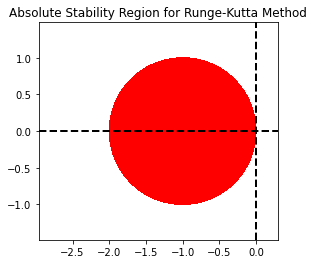

In [95]:
## We will see soon how to write a RK method
## This is explicit Euler and we plot the stability region
A=np.array([[0]])
b=np.array([1])
exEuler=runge_kutta_method.ExplicitRungeKuttaMethod(A,b)
p,q=exEuler.stability_function()
print(p)
exEuler.plot_stability_region();

#### How can we insure the belonging to the stability region?
We want $z=q\Delta t$ to stay in the stability region. On $q$ we do not have control, hence, we can only modify $\Delta t$. 
In particular, denoting $q=p+ir$ with $p,r \in \mathbb R $ and $p\leq 0$, the stability relation we have seen before leads to at least check that the real part verifies the relation

$$
|1+\Delta t p + i \Delta t r|\leq 1 \\
1-\Delta t |p|  \geq 1\\
\Delta t \leq \frac{2}{|p|}
$$

where $|p|$ is for sure bounded by the Lipschitz constant $L$ of the function $F$.

So, it is necessary to check that

$$
\Delta t \leq \frac{2}{L}.
$$

This can be generalized also for nonlinear problems.

## Implicit Euler <a id='implicitEuler'></a>

The implicit Euler method approximates our problem with the following strategy

$$
y^{n+1}=y^n +\Delta t f(t^{n+1},y^{n+1}).
$$

1. It is not always easy to find the solution of such method, for example when $f$ is nonlinear, one may need nonlinear solvers to find the solution (e.g. Newton method, Broyden, and so on)
1. We can compute the error estimate similarly to explicit Euler, obtaining that also implicit Euler is a *first* order method
1. More interesting are the **stability** property of this scheme.

Consider again the Dahlquist's equation

$$y'=qy$$

and the implicit Euler method

$$
\begin{align}
y^{n+1}=y^n+ \Delta t q y^{n+1},\\
(1-\Delta t q) y^{n+1}=y^n,\\
y^{n+1}=\frac{1}{1-\Delta t q} y^n.
\end{align}
$$

So the stability function is $R(z)=\frac{1}{1-z}$ and the stability region $\mathcal S := \lbrace z \in \mathbb C : |R(z)|\leq 1 \rbrace$ contains the whole left complex semiplane. Indeed, if Re$(z)\leq 0$, then Re$(1-z)\geq 1$ and $|1-z|\geq 1$.
So, $R(z)\leq 1$.

 
1
 
-1 x + 1


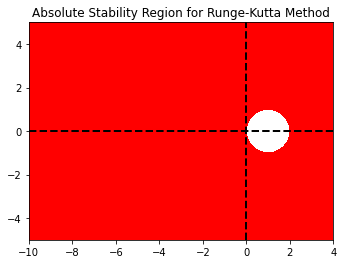

In [96]:
## We will see soon how to write a RK method
## This is implicit Euler and we plot the stability region
A=np.array([[1]])
b=np.array([1])
imEuler=runge_kutta_method.RungeKuttaMethod(A,b)
p,q=imEuler.stability_function()
print(p)
print(q)
imEuler.plot_stability_region(bounds=[-10,4, -5,5]);

#### Unconditionally TVD/positivity preserving
For some class of linear problems, it can be shown that for positive systems it is **positivity preserving**, or more in general for finite difference method in hyperbolic conservation laws, it is total variation diminishing (TVD).

The clou is that these properties are true independently on the size of $\Delta t$.

For TVD one can read the SSPRK article by Gottlieb, Shu and Tadmor [link](https://www.researchgate.net/publication/2365594_Strong_Stability-Preserving_High-Order_Time_Discretization_Methods).

##### TVD for incremental form problem
The implicit Euler method for incremental problems, i.e.,
$$
U^{n+1}_j=U^{n}_j +\Delta t \left [ C_{j+1/2}(U_{j+1}^{n+1}-U_{j}^{n+1})-D_{j-1/2}(U_{j}^{n+1}-U_{j-1}^{n+1}) \right]
$$

where $C_{j+1/2},D_{j+1/2}\geq 0$ is TVD independently on $\Delta t$.

###### Proof (Harten)
Define 

$$
TV(U^n) = \sum_j |U^n_{j+1}-U^n_j|.
$$

We can compute
$$
U^{n+1}_j=U^{n}_j +\Delta t \left [ C_{j+1/2}(U_{j+1}^{n+1}-U_{j}^{n+1})-D_{j-1/2}(U_{j}^{n+1}-U_{j-1}^{n+1}) \right]\\
[1+\Delta t (C_{j+1/2}+D_{j+1/2})](U^{n+1}_j-U_j^{n+1})=U^{n}_j-U_j^{n} +\Delta t \left [ C_{j+3/2}(U_{j+2}^{n+1}-U_{j+1}^{n+1})+D_{j-1/2}(U_{j}^{n+1}-U_{j-1}^{n+1}) \right]\\
[1+\Delta t (C_{j+1/2}+D_{j+1/2})]|U^{n+1}_j-U_j^{n+1}|\leq|U^{n}_j-U_j^{n}| +\Delta t \left [ C_{j+3/2}|U_{j+2}^{n+1}-U_{j+1}^{n+1}|+D_{j-1/2}|U_{j}^{n+1}-U_{j-1}^{n+1}| \right]=\\
TV(U^{n+1}) +\Delta t \sum_j(C_{j+1/2}+D_{j+1/2})|U^{n+1}_{j+1}-U^{n+1}_j| \leq TV(U^{n}) +\Delta t \sum_j(C_{j+1/2}+D_{j+1/2})|U^{n+1}_{j+1}-U^{n+1}_j| \\
TV(U^{n+1}) \leq TV(U^n).
$$

Reminder: Total variation diminishing means for conservation laws, that if the initial solution is positive, it stays positive.


##### Positivity for production destruction system
We will see the positivity for a specific case: a production-destruction system with constant coefficient. It can be written as

$$
y'=My
$$

with 

$$
M_{ii}<0,\qquad M_{ij}>0,\, i\neq j, \qquad \sum_{i}M_{ij}=0.
$$

The linear system at the beginning of this chapter falls in this example.

This system is positive if $y_i^0\geq 0$. The implicit Euler is also positive.

$$
(I-\Delta t M)y^{n+1}= y^{n}
$$

##### Theorem
Defining with $A:=I-\Delta t M$, we can prove that $A$ is non singular and that $A^{-1}\geq 0$, i.e., every entry of the matrix is nonnegative.

##### Proof
1. $A$ is strictly diagonally dominant by columns
Indeed, 

$$
0< A_{ii} = 1+\Delta t |M_{ii}| > \Delta t \sum_{j:j\neq i} |M_{ij}| = \sum_{j:j\neq i} |A_{ij}|
$$

Hence, $A$ is nonsingular.

2. The Jacobi method converge and the Jacobi Matrix is positive [Jacobi method](https://en.wikipedia.org/wiki/Jacobi_method)


Define the Jacobi matrix $B=D^{-1}(D-A^T)$, with $D=\text{diag}(A)$.
The diagonal of $B$ is 0 and each element on the off diagonal terms are

$$
B_{ij}=\frac{-A_{ij}}{A_{ii}}, \quad j\neq i. 
$$

So, the spectral radius of $B$ is bounded by

$$
\rho(B)\leq ||B||_{\infty} =\max_{i}\sum_{j\neq i} \frac{|A_{ij}|}{|A_{ii}|} \leq 1.
$$

The iterative Jacobi method is convergent to the solution of $Ay^{n+1}=y^n$.

The method reads

$$
w^{(k+1)}=D^{-1}(y^n- (D-A^T)w^{(k)})
$$

which is a linear combination of positive matrices and vectors. Hence, the solutions $w^{(k)}$ stay positive if $y^n$ is positive.



In [25]:
# Simple implementation of the implicit Euler for Linear systems y'=My
# Input are M, (t^0,...,t^N), y_0
def implicitEulerLinear(M, tspan, y_0):
    N_time=len(tspan)  # N+1
    dim=len(y_0)          # S
    y=np.zeros((dim,N_time))    # initializing the variable of solutions    
    y[:,0]=y_0                 # first timestep 
    for n in range(N_time-1):    # n=0,..., N-1
        A=np.eye(dim)-(tspan[n+1]-tspan[n])*M
        y[:,n+1]=np.linalg.solve(A,y[:,n])
    return tspan, y 

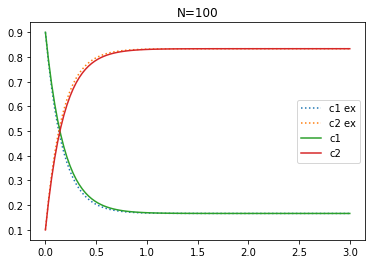

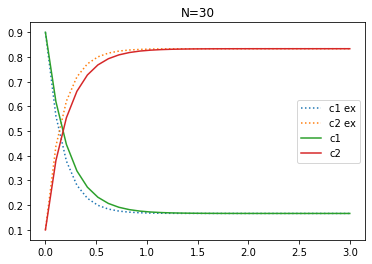

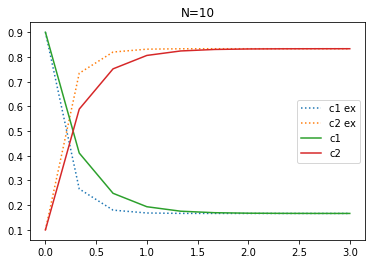

In [26]:
def linSysF(y,t=0):
    # evolution function 
    F=np.zeros(np.shape(y))
    F[0] = y[1]-5*y[0]
    F[1] = -F[0]
    return F

linSysM=np.array([[-5,1],[5,-1]])

for N in [100,30,10]:
    tspan=np.linspace(0,3,N)
    y0=np.array([0.9,0.1])

    tt,yy=implicitEulerLinear(linSysM,tspan,y0)

    A=np.array([[-5,1],[5,-1]])

    y_exact=np.zeros((len(y0),len(tt)))
    for it, t in enumerate(tt):
        y_exact[:,it]=y0+(1-np.exp(-6*t))/6*np.dot(A,y0)

    plt.figure()
    plt.plot(tt,y_exact[0,:],":", label="c1 ex")
    plt.plot(tt,y_exact[1,:],":", label="c2 ex")

    plt.plot(tt,yy[0,:],label="c1")
    plt.plot(tt,yy[1,:],label="c2")
    plt.title("N=%d"%N)
    plt.legend()

#### Let's check the order of accuracy of the implicit and explicit Euler!

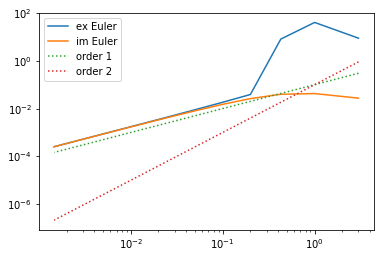

In [27]:
# Convergence error
def linSysF(y,t=0):
    # evolution function 
    F=np.zeros(np.shape(y))
    F[0] = y[1]-5*y[0]
    F[1] = -F[0]
    return F

linSysM=np.array([[-5,1],[5,-1]])

y0=np.array([0.9,0.1])

def exact_sol(t):
    return y0+(1-np.exp(-6*t))/6*np.dot(linSysM,y0)

def error(tt,yy):
    errors=np.zeros(len(tt))
    for it, t in enumerate(tt):
        errors[it]=np.linalg.norm(yy[:,it]-exact_sol(t))
    return np.mean(errors)

Ns=[2**k for k in range(1,12)]
errorEx=np.zeros(len(Ns))
errorIm=np.zeros(len(Ns))
dts=    np.zeros(len(Ns))


for iN, N in enumerate(Ns):
    tspan=np.linspace(0,3,N)
    dts[iN]=tspan[1]-tspan[0]
    
    tt,yy=explicitEuler(linSysF,tspan,y0)
    errorEx[iN]=error(tt,yy)
    tt,yy=implicitEulerLinear(linSysM,tspan,y0)
    errorIm[iN]=error(tt,yy)

plt.figure()
plt.loglog(dts,errorEx,label="ex Euler")
plt.loglog(dts,errorIm, label="im Euler")
plt.loglog(dts,0.1*dts,":", label="order 1")
plt.loglog(dts,0.1*dts**2., ":", label="order 2")
plt.legend()

## Extra exercise: code implicit Euler for nonlinear fluxes
* Use a nonlinear solver to solve $y^{n+1}-\Delta t F(y^{n+1},t^{n+1})=y^n$ (**scipy.optimize.newton**, scipy.optimize.broyden1)
* Use lambda function to define the nonlinear function 
* Search the documentation on Google

In [90]:
# Simple implementation of the method
# Input are F, (t^0,...,t^N), y_0
def implicitEuler(func, tspan, y_0):
    N_time=len(tspan)  # N+1
    dim=len(y_0)          # S
    y=np.zeros((dim,N_time))    # initializing the variable of solutions    
    y[:,0]=y_0                 # first timestep 
    for n in range(N_time-1):    # n=0,..., N-1
        nonLinearFunc = lambda yn1: yn1 -y[:,n] -(tspan[n+1]-tspan[n])*func(yn1,tspan[n+1])
        z = optimize.newton(nonLinearFunc, y[:,n]) 
        y[:,n+1] = z
    return tspan, y 

In [78]:
## Nonlinear 3x3 system production destruction
def nonlinear_system3_flux(u,t=0):
    ff=np.zeros(len(u))
    ff[0]= -u[0]*u[1]/(u[0]+1)
    ff[1]= u[0]*u[1]/(u[0]+1) -0.3*u[1]
    ff[2]= 0.3*u[1]
    return ff

y_0 = np.array([9.98,0.01,0.01])
T_fin = 30

29.6969696969697


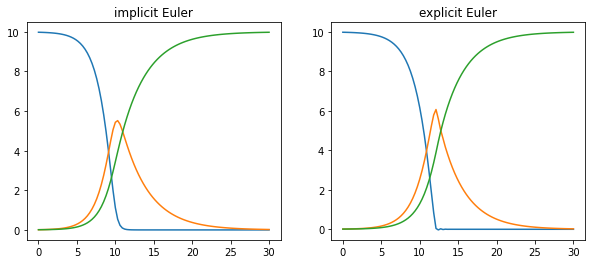

In [89]:
## Run implicit Euler method and plot the solution
tt=np.linspace(0,T_fin, 100)
tt,yy = implicitEuler(nonlinear_system3_flux, tt, y_0)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("implicit Euler")
plt.plot(tt,yy[0,:])
plt.plot(tt,yy[1,:])
plt.plot(tt,yy[2,:])


tt,yy = explicitEuler(nonlinear_system3_flux, tt, y_0)
plt.subplot(122)
plt.title("explicit Euler")
plt.plot(tt,yy[0,:])
plt.plot(tt,yy[1,:])
plt.plot(tt,yy[2,:])

In [91]:
## Nonlinear stiff problem: Robertson

def Robertson_flux(u,t=0,alpha=10**4,beta=0.04, gamma=3*10**7):
    ff=np.zeros(np.shape(u))
    ff[0] = alpha*u[1]*u[2]-beta*u[0]
    ff[1] = beta*u[0]-alpha*u[1]*u[2] - gamma*u[1]**2
    ff[2] = gamma*u[1]**2
    return ff

tt = np.array([10**k for k in np.linspace(-7,11,10000)])
y_0 = np.array([1.,10**-20,10**-20])

/home/accdavlo/anaconda3/lib/python3.8/site-packages/scipy/optimize/zeros.py:459: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)


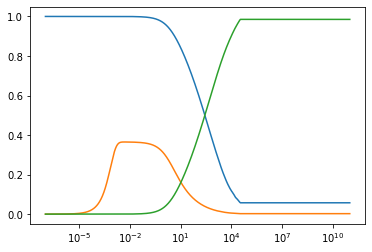

In [92]:
tt,yy = implicitEuler(Robertson_flux, tt, y_0)
plt.semilogx(tt,yy[0,:])
plt.semilogx(tt,yy[1,:]*10**4)
plt.semilogx(tt,yy[2,:])

<ipython-input-91-ffe2e2ae1e9f>:5: RuntimeWarning: overflow encountered in double_scalars
  ff[0] = alpha*u[1]*u[2]-beta*u[0]
<ipython-input-91-ffe2e2ae1e9f>:6: RuntimeWarning: overflow encountered in double_scalars
  ff[1] = beta*u[0]-alpha*u[1]*u[2] - gamma*u[1]**2
<ipython-input-91-ffe2e2ae1e9f>:6: RuntimeWarning: invalid value encountered in double_scalars
  ff[1] = beta*u[0]-alpha*u[1]*u[2] - gamma*u[1]**2
<ipython-input-91-ffe2e2ae1e9f>:7: RuntimeWarning: overflow encountered in double_scalars
  ff[2] = gamma*u[1]**2


(-0.05, 1.05)

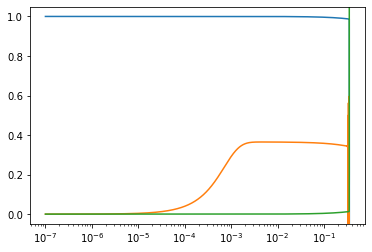

In [94]:
tt,yy = explicitEuler(Robertson_flux, tt, y_0)
plt.semilogx(tt,yy[0,:])
plt.semilogx(tt,yy[1,:]*10**4)
plt.semilogx(tt,yy[2,:])
plt.ylim([-0.05, 1.05])